In [ ]:
# Uncomment and install packages if not done already
# !pip install duckdb numpy pandas matplotlib scikit-learn xgboost kaggle

import duckdb
import numpy as np
import pandas as pd
import os
import json
import zipfile
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve, auc
import xgboost as xgb
import pickle

In [ ]:
# Clone data to local environment
!git clone https://github.com/hazourahh/big-data-course-2024-projects

Cloning into 'big-data-course-2024-projects'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 133 (delta 13), reused 5 (delta 5), pack-reused 110
Receiving objects: 100% (133/133), 5.88 MiB | 18.70 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [ ]:
# Set up the .kaggle directory in the user's home directory
kaggle_directory = os.path.join(os.path.expanduser('~'), '.kaggle')
os.makedirs(kaggle_directory, exist_ok=True)

# Path to the kaggle.json file
kaggle_json_path = os.path.join(kaggle_directory, 'kaggle.json')

# Your API token
api_token = {"username":"sionasassadad","key":"7da08a57c9f0a89b0d32887d08c561db"}

# Save the API token to kaggle.json
with open(kaggle_json_path, 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d rounakbanik/the-movies-dataset

# Unzipping the dataset
zip_file_path = '/content/the-movies-dataset.zip'
unzip_location = '/content/unzipped-movies'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_location)


 98% 224M/228M [00:07<00:00, 40.5MB/s]
100% 228M/228M [00:07<00:00, 31.3MB/s]


# Data Ingestion

[linktekst](https://)DuckDB is used for the data ingest part since we don't have a lot of data to work with and PySpark isn't necessary. With small to medium datasets, DuckDB operates fairly quickly, so we don't need to spend more computing power as it would be a waste of resources.

In [ ]:
## establish duck db in-memory connection
conn = duckdb.connect()

## create one table from all training data
conn.sql("""
            CREATE TABLE training_unioned as
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-1.csv')
                UNION ALL
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-2.csv')
                UNION ALL
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-3.csv')
                UNION ALL
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-4.csv')
                UNION ALL
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-5.csv')
                UNION ALL
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-6.csv')
                UNION ALL
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-7.csv')
                UNION ALL
                SELECT * FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/train-8.csv')
                UNION ALL
                SELECT *, 'unknown_validation' as label, FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/validation_hidden.csv')
                UNION ALL
                SELECT *, 'unknown_test' as label FROM read_csv_auto('/content/big-data-course-2024-projects/imdb/test_hidden.csv')
            """)

## create table from the writing data
conn.sql("CREATE TABLE writer AS SELECT * FROM '/content/big-data-course-2024-projects/imdb/writing.json'")

## unnest and create table from the directors data
conn.sql('''
        CREATE TABLE director AS
                SELECT
                    replace(cast(unnest(json_extract(movie, '$.*')) as varchar), '\"', '') as movie,
                    replace(cast(unnest(json_extract(director, '$.*')) as varchar), '\"', '') as director

                FROM read_json('/content/big-data-course-2024-projects/imdb/directing.json',format='auto', columns={movie:'VARCHAR', director:'VARCHAR'})
        '''
        )

## import external data
conn.sql(""" CREATE TABLE tmdb_data AS
        SELECT imdb_id, release_date, genres, original_language, popularity, vote_average, vote_count FROM read_csv_auto('/content/unzipped-movies/movies_metadata.csv', ignore_errors=true)
        """)

### join tables
conn.sql('''
        CREATE TABLE training_set AS
        select
            tconst as imdbId,
            primaryTitle as title,
            originalTitle as originalTitle,
            CASE WHEN
              CAST(IF(startYear == '\\N', endYear, startYear) as INT64) != year(CAST(release_date as DATE))
            THEN year(CAST(release_date as DATE))
            ELSE CAST(IF(startYear == '\\N', endYear, startYear) as INT64)
            END as startYear,
            cast(REPLACE(runtimeMinutes, '\\N', '0') as INT64) as runtimeMinutes,
            numVotes,
            director,
            writer,
            label,
            genres,
            original_language,
            popularity,
            vote_average,
            vote_count,

        from training_unioned
        left join writer
        on training_unioned.tconst = writer.movie
        left join director
        on training_unioned.tconst = director.movie
        left join tmdb_data
        on training_unioned.tconst = tmdb_data.imdb_id
        ''')

## Switching to Pandas for null value handling

We do this because this part is relatively fast (matter of seconds). In order to save complexity and keep the pipeline understandable we therefore manipulate it with pandas here.

In [ ]:
df = conn.sql("SELECT * FROM training_set").df()

df

,imdbId,title,originalTitle,startYear,runtimeMinutes,numVotes,director,writer,label,genres,original_language,popularity,vote_average,vote_count
0,tt0114709,Tớy Stớry,Toy Story,1995,81,937386.0,nm0005124,nm0812513,true,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,21.946943,7.7,5415.0
1,tt0113277,Heat,Heat,1995,170,616475.0,nm0000520,nm0000520,true,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",en,17.924927,7.7,1886.0
2,tt0113189,GoldenEye,None,1995,130,250071.0,nm0132709,nm0270761,true,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",en,14.686036,6.6,1194.0
3,tt0112453,Balto,None,1995,78,42057.0,nm0920425,nm0776107,true,"[{'id': 10751, 'name': 'Family'}, {'id': 16, '...",en,12.140733,7.1,423.0
4,tt0113987,Nixon,None,1995,192,30228.0,nm0000231,nm0000231,true,"[{'id': 36, 'name': 'History'}, {'id': 18, 'na...",en,5.092000,7.1,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27893,tt3547616,Áll Is Wéll,None,2015,126,1564.0,nm1084488,nm5046012,false,None,None,NaN,NaN,NaN
27894,tt3547616,Áll Is Wéll,None,2015,126,1564.0,nm1084488,nm5378778,false,None,None,NaN,NaN,NaN
27895,tt7979580,Thé Mitchélls vs thé Máchinés,None,2021,113,NaN,nm6676487,nm5106831,true,None,None,NaN,NaN,NaN
27896,tt7979580,Thé Mitchélls vs thé Máchinés,None,2021,113,NaN,nm6676487,nm6676487,true,None,None,NaN,NaN,NaN


# Handling Null Values & One-hot encoding

We shouldn't be dropping rows as we want to do prediction on them in the final validation and test. Therefore we will handle this to fill null values with the median.

In [ ]:
# Group by 'imdbId' and aggregate the unique directors and writers into lists
aggregated_df = df.groupby('imdbId').agg({
    'startYear': 'first',
    'runtimeMinutes': 'first',
    'numVotes': 'first',
    'vote_average': 'first',
    'vote_count': 'first',
    'genres' : 'first',
    'original_language': 'first',
    'popularity':'first',
    'director': lambda x: list(set(x)),  # Remove duplicates and aggregate into a list
    'writer': lambda x: list(set(x)),    # Remove duplicates and aggregate into a list
    'label': 'first'
}).reset_index()

aggregated_df['numDirectors'] = aggregated_df['director'].apply(len)
aggregated_df['numWriters'] = aggregated_df['writer'].apply(len)
aggregated_df = aggregated_df.drop(columns=['director', 'writer'])

aggregated_df = pd.get_dummies(aggregated_df, columns=['original_language'])
aggregated_df.set_index('imdbId')

aggregated_df.shape

(10000, 71)

In [ ]:
# Fill null values with median
mean_numVotes = aggregated_df['numVotes'].median()
aggregated_df['numVotes'] = aggregated_df['numVotes'].fillna(mean_numVotes)

# Fill null values with median
mean_runtimeMinutes = aggregated_df['runtimeMinutes'].median()
aggregated_df['runtimeMinutes'] = aggregated_df['runtimeMinutes'].fillna(mean_runtimeMinutes)

# Fill external data with mean
vote_average_median = aggregated_df['vote_average'].mean()
aggregated_df['vote_average'] = aggregated_df['vote_average'].fillna(vote_average_median)

vote_count_median = aggregated_df['vote_count'].mean()
aggregated_df['vote_count'] = aggregated_df['vote_count'].fillna(vote_count_median)

popularity_median = aggregated_df['popularity'].median()
aggregated_df['popularity'] = aggregated_df['popularity'].fillna(popularity_median)

aggregated_df = aggregated_df.fillna('Unknown')

In [ ]:
# Function to extract and flatten genres from the structured format
def extract_genres(genres_str):
    try:
        genres_list = json.loads(genres_str.replace("'", '"'))  # Ensure proper JSON format
        return [genre['name'] for genre in genres_list]  # Extract the genre names
    except (TypeError, json.decoder.JSONDecodeError):
        return []  # Return an empty list if there's an issue with the data

# Apply the function to the genres column
aggregated_df['genres'] = aggregated_df['genres'].apply(extract_genres)

# Extract unique genres
all_genres = set(genre for sublist in aggregated_df['genres'] for genre in sublist)

# Create new columns for each genre and initialize to 0
for genre in all_genres:
    aggregated_df[genre] = 0

# Populate the one-hot encoded columns
for index, row in aggregated_df.iterrows():
    for genre in row['genres']:
        aggregated_df.at[index, genre] = 1

aggregated_df.drop('genres', axis=1, inplace=True)

df_encoded = aggregated_df.copy()

df_encoded.set_index('imdbId', inplace=True)

df_encoded

,startYear,runtimeMinutes,numVotes,vote_average,vote_count,popularity,label,numDirectors,numWriters,original_language_ab,...,TV Movie,Drama,Foreign,Action,History,Comedy,Documentary,Thriller,Science Fiction,Fantasy
imdbId,,,,,,,,,,,,,,,,,,,,,
tt0003740,1914,148,3452.0,6.800000,22.000000,0.704028,unknown_validation,1,4,0,...,0,1,0,0,1,0,0,0,0,0
tt0008663,1917,65,1882.0,6.600000,11.000000,1.322761,unknown_validation,1,3,0,...,0,1,0,0,0,0,0,0,0,0
tt0009369,1918,93,1119.0,7.500000,4.000000,0.211008,false,2,2,0,...,0,1,0,0,0,1,0,0,0,0
tt0010307,1919,166,1692.0,7.900000,7.000000,0.834679,unknown_validation,1,1,0,...,0,1,0,0,0,0,0,0,0,0
tt0010600,1919,66,1898.0,6.118186,210.689585,2.558118,true,1,4,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9850344,2020,98,1325.0,6.118186,210.689585,2.558118,false,1,3,0,...,0,0,0,0,0,0,0,0,0,0
tt9850386,2020,111,4144.0,6.118186,210.689585,2.558118,true,1,1,0,...,0,0,0,0,0,0,0,0,0,0
tt9900782,2019,145,3526.5,6.118186,210.689585,2.558118,true,1,2,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_encoded["numDirectors"].sort_values()

imdbId
tt1438535      1
tt14318430     1
tt1433822      1
tt1434447      1
tt1436559      1
              ..
tt0099273     13
tt2275743     13
tt0401711     21
tt1935896     27
tt1687247     35
Name: numDirectors, Length: 10000, dtype: int64

# Feature engineering

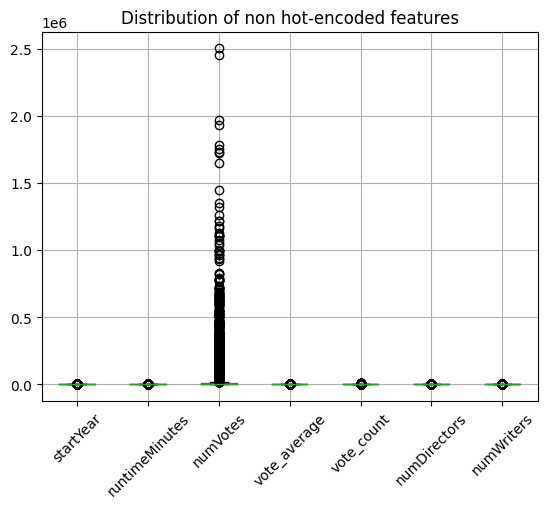

In [ ]:
df_encoded.boxplot(['startYear', 'runtimeMinutes', 'numVotes', 'vote_average', 'vote_count', 'numDirectors', 'numWriters'])
plt.title('Distribution of non hot-encoded features')
plt.xticks(rotation=45)
plt.show()

Number of votes seems to have great variance in its distribution

In [ ]:
df_encoded["numVotes"].sort_values()

imdbId
tt1723596       1001.0
tt3681440       1001.0
tt1564369       1001.0
tt6515200       1001.0
tt2181855       1002.0
               ...    
tt0133093    1787064.0
tt0109830    1932502.0
tt0137523    1969585.0
tt0468569    2453191.0
tt0111161    2503641.0
Name: numVotes, Length: 10000, dtype: float64

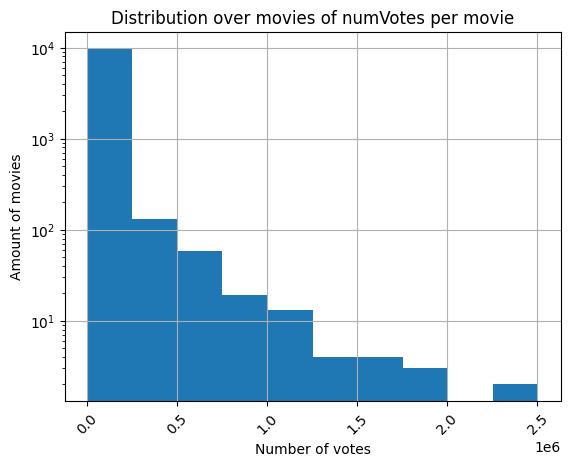

In [ ]:
df_encoded["numVotes"].hist(bins = 10, log = True)
plt.title('Distribution over movies of numVotes per movie')
plt.xticks(rotation=45)
plt.ylabel("Amount of movies")
plt.xlabel("Number of votes")
plt.show()

Now to check the other variables..

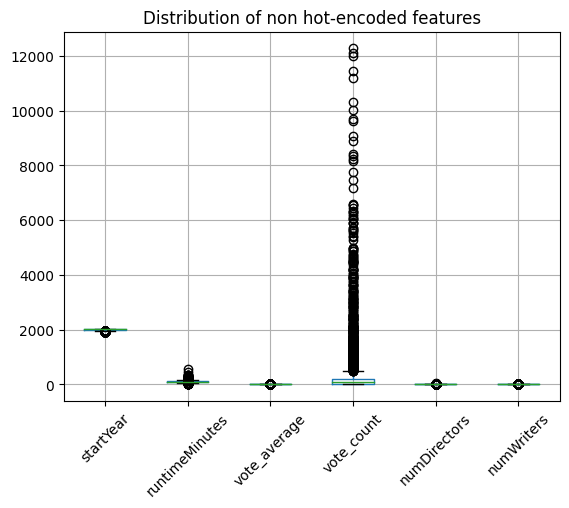

In [ ]:
df_encoded.boxplot(['startYear', 'runtimeMinutes', 'vote_average', 'vote_count', 'numDirectors', 'numWriters'])
plt.title('Distribution of non hot-encoded features')
plt.xticks(rotation=45)
plt.show()

same seems to be the case for vote_count

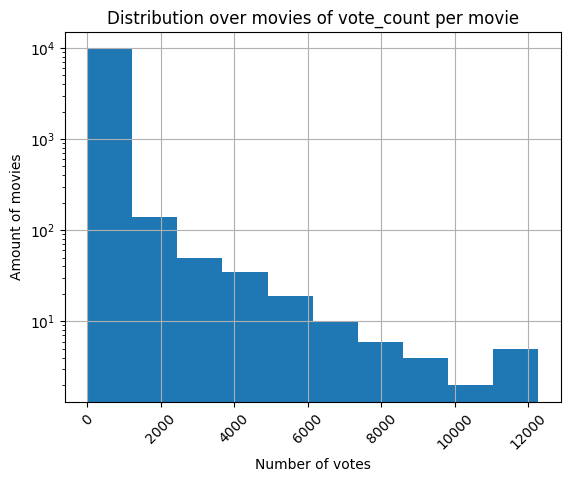

In [ ]:
df_encoded["vote_count"].hist(bins = 10, log = True)
plt.title('Distribution over movies of vote_count per movie')
plt.xticks(rotation=45)
plt.ylabel("Amount of movies")
plt.xlabel("Number of votes")
plt.show()

# Feature Extraction: Scaling

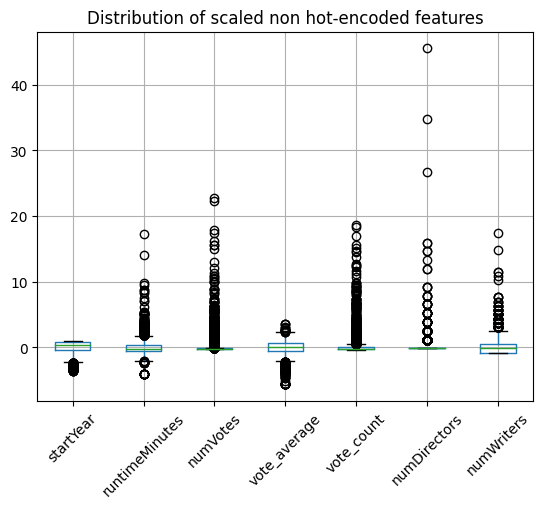

,startYear,runtimeMinutes,numVotes,vote_average,vote_count,popularity,numDirectors,numWriters,original_language_ab,original_language_af,...,TV Movie,Drama,Foreign,Action,History,Comedy,Documentary,Thriller,Science Fiction,Fantasy
imdbId,,,,,,,,,,,,,,,,,,,,,
tt0009369,-3.641899,-0.486370,-0.237129,1.280957,-0.321211,-0.569194,1.181337,-0.162992,-0.01121,-0.01121,...,-0.025072,1.392895,-0.149062,-0.366616,-0.165825,1.935452,-0.211571,-0.412845,-0.24995,-0.207322
tt0010600,-3.596426,-1.535712,-0.229975,0.006814,-0.001682,-0.214325,-0.162803,1.134907,-0.01121,-0.01121,...,-0.025072,-0.717929,-0.149062,-0.366616,-0.165825,-0.516675,-0.211571,-0.412845,-0.24995,-0.207322
tt0011439,-3.550953,-1.030473,-0.225007,0.174461,-0.318119,-0.550175,-0.162803,0.485958,-0.01121,-0.01121,...,-0.025072,1.392895,-0.149062,2.727652,-0.165825,-0.516675,-0.211571,-0.412845,-0.24995,-0.207322
tt0011607,-3.550953,-0.447506,-0.235797,0.006814,-0.001682,-0.214325,-0.162803,-0.162992,-0.01121,-0.01121,...,-0.025072,-0.717929,-0.149062,-0.366616,-0.165825,-0.516675,-0.211571,-0.412845,-0.24995,-0.207322
tt0011841,-3.550953,1.534584,-0.198035,0.082253,-0.293384,-0.351629,-0.162803,1.783856,-0.01121,-0.01121,...,-0.025072,1.392895,-0.149062,2.727652,-0.165825,-0.516675,-0.211571,-0.412845,-0.24995,-0.207322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9850344,0.996379,-0.292048,-0.235237,0.006814,-0.001682,-0.214325,-0.162803,0.485958,-0.01121,-0.01121,...,-0.025072,-0.717929,-0.149062,-0.366616,-0.165825,-0.516675,-0.211571,-0.412845,-0.24995,-0.207322
tt9850386,0.996379,0.213191,-0.209349,0.006814,-0.001682,-0.214325,-0.162803,-0.811941,-0.01121,-0.01121,...,-0.025072,-0.717929,-0.149062,-0.366616,-0.165825,-0.516675,-0.211571,-0.412845,-0.24995,-0.207322
tt9900782,0.950906,1.534584,-0.215020,0.006814,-0.001682,-0.214325,-0.162803,-0.162992,-0.01121,-0.01121,...,-0.025072,-0.717929,-0.149062,-0.366616,-0.165825,-0.516675,-0.211571,-0.412845,-0.24995,-0.207322


In [ ]:
# Start with scaling the training data apart from the final submission validation and test set
df_train_X = df_encoded[(df_encoded['label'] == 'true') | (df_encoded['label'] == 'false')].drop(columns=['label'])
df_train_y = df_encoded[(df_encoded['label'] == 'true') | (df_encoded['label'] == 'false')]['label']

scaler = StandardScaler()
df = scaler.fit_transform(df_train_X, df_train_y)
df_encoded_scaled = pd.DataFrame(df, columns=df_train_X.columns, index=df_train_X.index)

df_encoded_scaled.boxplot(['startYear', 'runtimeMinutes', 'numVotes', 'vote_average', 'vote_count', 'numDirectors', 'numWriters'])
plt.title('Distribution of scaled non hot-encoded features')
plt.xticks(rotation=45)
plt.show()

# Splitting Data
- Seperately scaled Train/Validation/Test split for submission (seperate labels from no-labels) <- We are not touching these until the very final predictions have to be made

- Train split into Train/Test for prediction evaluation (split labels)

In [ ]:
# Create seperate dataframes for the validation submission to the server
X_validation_submission = df_encoded[(df_encoded['label'] == 'unknown_validation')].drop(columns=['label'])

df = scaler.fit_transform(X_validation_submission)
X_validation_submission = pd.DataFrame(df, columns=X_validation_submission.columns, index=X_validation_submission.index)

# Create seperate dataframes for the test submission to the server
X_test_submission = df_encoded[(df_encoded['label'] == 'unknown_test')].drop(columns=['label'])

df = scaler.fit_transform(X_test_submission)
X_test_submission = pd.DataFrame(df, columns=X_test_submission.columns, index=X_test_submission.index)

# Split of the training data (labeled) to train/test split
X_train, X_test, y_train, y_test = train_test_split(df_encoded_scaled, df_train_y, test_size=0.2, random_state=42)

# Encode labels to 0 or 1
y_train = y_train.map({'true': 1, 'false': 0})
y_test = y_test.map({'true': 1, 'false': 0})

# Count labels
y_train.value_counts()

0    3204
1    3163
Name: label, dtype: int64

The labels are almost completely balanced, so no under or oversampling is needed.

# Hyperparameters

I have ran a one-off hyperparameter tuning in advance for a model with the variables: startYear, runtimeMinutes, numVotes (unscaled & excluding the one-hot encoded labels).

These are the results from a gridsearch, so I manually put these hyperparameters so we don't have to process them all the time.

In [ ]:
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# # Assuming X_train and y_train are already defined

# # Define the parameter grid
# param_grid = {
#     'max_depth': [3, 4, 5, 6],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'n_estimators': [100, 200, 300],
#     'colsample_bytree': [0.5, 0.7, 1.0],
#     'subsample': [0.6, 0.8, 1.0]
# }

# # Initialize the XGBoost classifier
# xgb_clf = xgb.XGBClassifier()

# # Set up the grid search with cross-validation
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=10, n_jobs=6)

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Extract the best parameters and the best model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Best parameters found: ", best_params)
# print("Best model accuracy: ", accuracy_score(y_train, best_model.predict(X_train)))


In [ ]:
best_dt_params = {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
best_rf_params = {'bootstrap': True, 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
best_xgb_params = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.6}

# Training and Evaluation

<ipython-input-98-06d46a0bbe33>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)
<ipython-input-98-06d46a0bbe33>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)
<ipython-input-98-06d46a0bbe33>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)


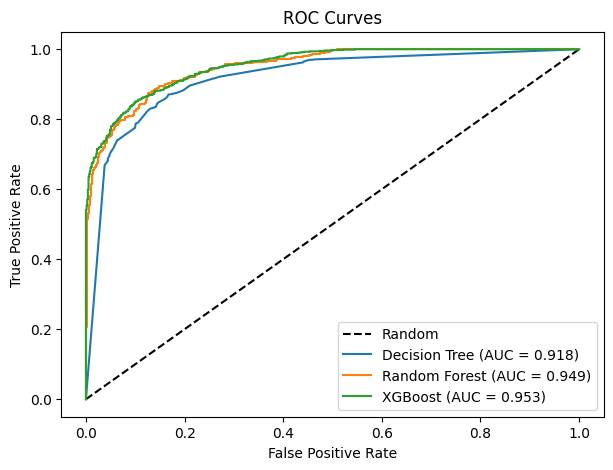

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.873,0.890,0.862,0.876
1,Random Forest,0.871,0.883,0.866,0.874
2,Decision Tree,0.840,0.890,0.791,0.837


In [ ]:
# Initialize models
models = [
    ("Decision Tree", DecisionTreeClassifier(**best_dt_params, random_state=42)),
    ("Random Forest", RandomForestClassifier(**best_rf_params, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(**best_xgb_params, random_state=42)),
]


# Initialize DataFrame to store scores
scores_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Prepare plot for ROC curves
plt.figure(figsize=(7, 5))
plt.plot([0, 1], [0, 1], 'k--', label="Random")

# Loop through models
for name, model in models:
    # Train the model
    model.fit(X_train, y_train)

    # Predict classes and probabilities
    y_pred = model.predict(X_test)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

    # Add scores to DataFrame
    scores_df = scores_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)

# Customize and show the ROC curve plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Display the scores table
display(scores_df.sort_values('Accuracy', ascending=False).round(3).reset_index(drop=True))

# Model Ensemble

As the accuracy of the three models are fairly similar, we can ensemble these to get a more robust model.

However, this does take a long time (around 10 minutes training time). So I suggest we should:

- Export the model and use a different pipeline where we don't retrain our model every time (good for creative/novelty points possibly)

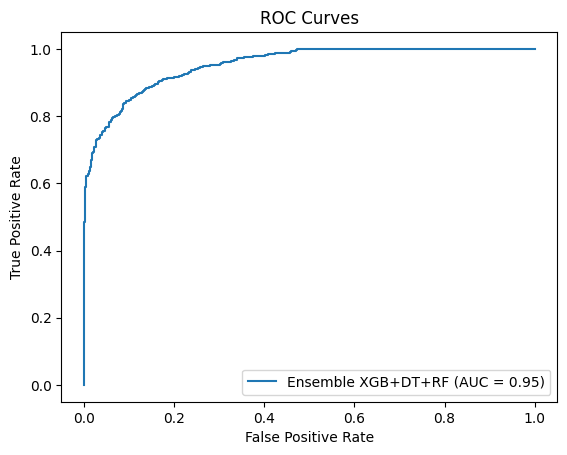

<ipython-input-99-4bde462e848c>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores_df = scores_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)


,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost,0.873,0.890,0.862,0.876
1,Ensemble XGB+DT+RF,0.872,0.884,0.868,0.876
2,Random Forest,0.871,0.883,0.866,0.874
3,Decision Tree,0.840,0.890,0.791,0.837


In [ ]:
# ENSEMBLING THE MODELS

from sklearn.ensemble import StackingClassifier

models = [
    ("Decision Tree", DecisionTreeClassifier(**best_dt_params, random_state=42)),
    ("Random Forest", RandomForestClassifier(**best_rf_params, random_state=42)),
    ("XGBoost", xgb.XGBClassifier(**best_xgb_params, random_state=42)),
]

model = StackingClassifier(estimators=models, final_estimator=LogisticRegression())
model.fit(X_train, y_train)

# Predict classes and probabilities
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
name = 'Ensemble XGB+DT+RF'
plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')


# Customize and show the ROC curve plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Add scores to DataFrame
scores_df = scores_df.append({'Model': name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}, ignore_index=True)


# Display the scores table
display(scores_df.sort_values('Accuracy', ascending=False).round(3).reset_index(drop=True))

# Save Model

What we also can do is to have trained the model one time and save the model so we don't have to re-train it at every run of the pipeline. We then just save the model and run a different piece of the pipeline for the predictions when we need them.



In [ ]:
# save
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

# load
with open('model.pkl', 'rb') as f:
    pretrained_model = pickle.load(f)

## Final predictions for server submission

In [ ]:
y_val = pretrained_model.predict(X_validation_submission)
y_test = pretrained_model.predict(X_test_submission)

In [ ]:
# Map numeric values to 'True' or 'False' and ensure they're treated as strings
y_val = pd.Series(y_val).map({1: "True", 0: "False"})
y_test = pd.Series(y_test).map({1: "True", 0: "False"})

# Save the predictions to text files
y_val.to_csv('validation_predictions_new.txt', index=False, header=False, sep='\t')
y_test.to_csv('test_predictions_new.txt', index=False, header=False, sep='\t')